**Attention**

This notebook is for experiment purpose. Since the actual output of the erbium concentration is descrete value, range from 0.01 to 0.05, and the variation between them is very small causing difficulty in accurate prediction. Therefore, this notebook is to shows the problem on the prediction and we will work on another notebook to treat it as classification task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.callbacks import EarlyStopping

In [2]:
!ls

sample_data  Structured_features.csv


In [3]:
data = pd.read_csv('Structured_features.csv')
data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,Erbium Concentration
0,60.505571,20.125896,33.671042,50.346610,0.250792,3.343693,2.390885,0.01
1,61.749309,20.539600,34.363176,51.381524,0.250792,3.412425,2.390885,0.01
2,60.206152,20.026301,33.504417,50.097465,0.250792,3.327146,2.390885,0.01
3,62.014179,20.627703,34.510575,51.601922,0.250792,3.427063,2.390885,0.01
4,62.831822,20.899675,34.965589,52.282281,0.250792,3.472248,2.390885,0.01
...,...,...,...,...,...,...,...,...
245,58.273308,19.835527,31.825938,49.270607,0.241979,3.411991,2.493001,0.05
246,57.141365,19.450228,31.207728,48.313539,0.241979,3.345714,2.493001,0.05
247,61.777979,21.028475,33.740012,52.233838,0.241979,3.617195,2.493001,0.05
248,58.251540,19.828118,31.814050,49.252202,0.241979,3.410717,2.493001,0.05


In [4]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

In [5]:
train_dataset[:10]

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,Erbium Concentration
225,66.425882,19.892242,39.902892,51.173172,0.286260,2.834518,1.994065,0.05
122,63.501343,18.969675,38.208442,48.828291,0.287009,2.693578,1.985915,0.03
92,59.015531,20.495892,31.687674,50.582029,0.233955,3.635216,2.587238,0.02
157,63.281998,20.478164,35.977780,51.637350,0.260791,3.265714,2.276757,0.04
154,75.022997,24.277571,42.652902,61.217865,0.260791,3.871616,2.276757,0.04
161,59.679243,18.848534,34.547864,47.844621,0.269187,2.900327,2.182310,0.04
198,56.367327,18.668075,31.476560,46.760089,0.252408,3.081379,2.372315,0.04
83,53.400675,16.862892,30.916819,42.806125,0.269240,2.594183,2.181711,0.02
63,53.422477,16.639074,31.237045,42.390490,0.273824,2.508910,2.130685,0.02
155,61.760233,19.985718,35.838374,50.558888,0.260791,3.197508,2.230650,0.04


In [6]:
data.isna().sum()

Longitudinal modulus         0
Shear modulus                0
Bulk modulus                 0
Young modulus                0
Poisson's ratio              0
Hardness                     0
fractal bond connectivity    0
Erbium Concentration         0
dtype: int64

In [7]:
col_name = list(data.columns)
col_name

['Longitudinal modulus',
 'Shear modulus',
 'Bulk modulus',
 'Young modulus',
 "Poisson's ratio",
 'Hardness',
 'fractal bond connectivity',
 'Erbium Concentration']

In [8]:
train_col_name = list(data.columns[:-1])
train_col_name

['Longitudinal modulus',
 'Shear modulus',
 'Bulk modulus',
 'Young modulus',
 "Poisson's ratio",
 'Hardness',
 'fractal bond connectivity']

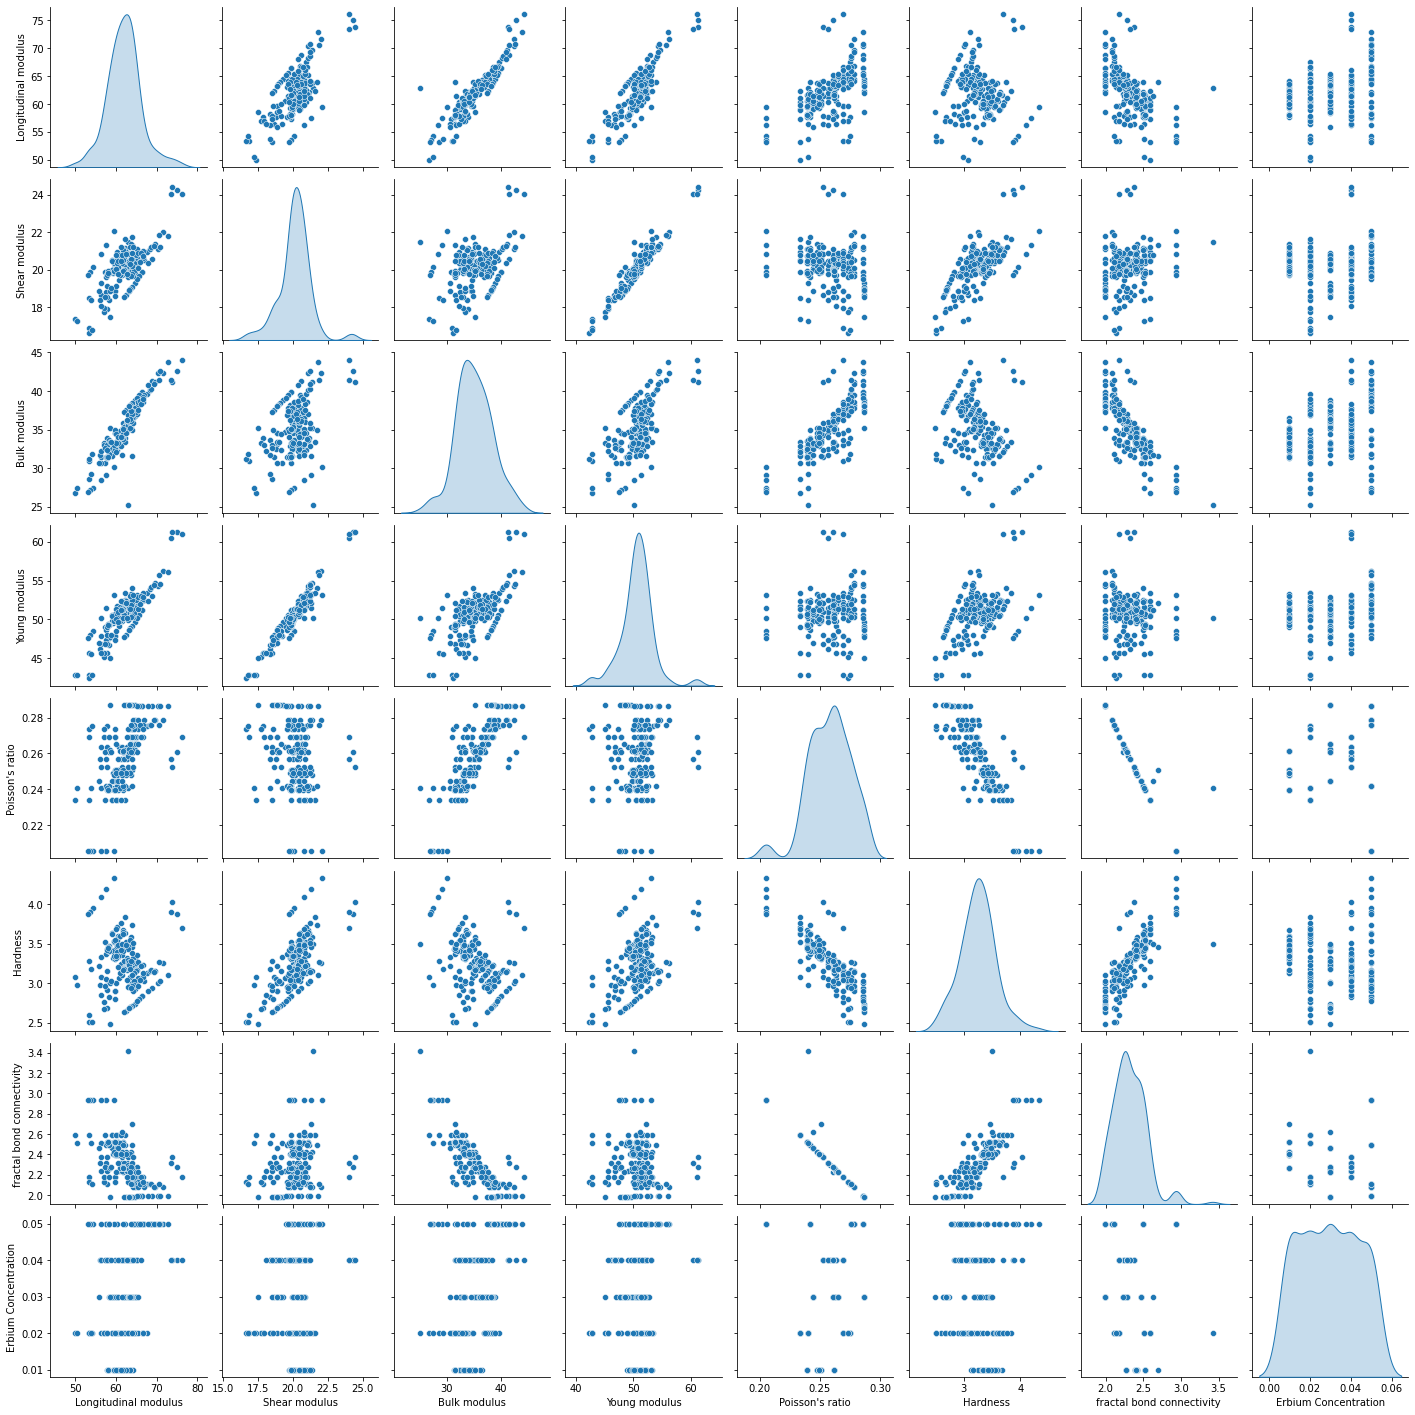

In [9]:
sns.pairplot(train_dataset[col_name], diag_kind='kde')

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Longitudinal modulus,200.0,61.954316,4.171997,49.954560,59.654638,61.808326,64.036460,76.161742
Shear modulus,200.0,20.138510,1.126002,16.639074,19.775765,20.141929,20.691405,24.432039
Bulk modulus,200.0,35.030650,3.358536,25.140928,32.949920,34.931123,37.297866,44.089459
Young modulus,200.0,50.644562,2.800587,42.390490,49.508251,50.745263,52.068897,61.217865
Poisson's ratio,200.0,0.258144,0.017449,0.205352,0.247204,0.260712,0.269240,0.287009
Hardness,200.0,3.247638,0.316471,2.484253,3.044602,3.251119,3.435733,4.333593
fractal bond connectivity,200.0,2.316184,0.217020,1.985915,2.181711,2.277646,2.462993,3.417749
Erbium Concentration,200.0,0.029600,0.014136,0.010000,0.020000,0.030000,0.040000,0.050000


In [11]:
# Collect input feature for training, molar volume value in this case
train_features = train_dataset.copy() #dataframe type
test_features = test_dataset.copy()

# Collect respective label, density value in this case
train_labels = train_features.pop('Erbium Concentration') # series type
test_labels = test_features.pop('Erbium Concentration')

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[61.954315  20.13851   35.03065   50.64456    0.2581441  3.247638
  2.3161843]


In [13]:
input_feature = np.array(train_features[train_col_name])

input_feature_normalizer = preprocessing.Normalization(input_shape=[1,])
input_feature_normalizer.adapt(input_feature)

In [14]:
basic_model = keras.Sequential([
    input_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [15]:
basic_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error')

In [16]:
train_features

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity
225,66.425882,19.892242,39.902892,51.173172,0.286260,2.834518,1.994065
122,63.501343,18.969675,38.208442,48.828291,0.287009,2.693578,1.985915
92,59.015531,20.495892,31.687674,50.582029,0.233955,3.635216,2.587238
157,63.281998,20.478164,35.977780,51.637350,0.260791,3.265714,2.276757
154,75.022997,24.277571,42.652902,61.217865,0.260791,3.871616,2.276757
...,...,...,...,...,...,...,...
183,60.422223,19.767204,34.065950,49.690441,0.256891,3.203724,2.321051
114,63.459155,20.283022,36.415126,51.320631,0.265113,3.176145,2.227978
163,62.626366,19.779326,36.253932,50.207318,0.269187,3.043553,2.182310
151,58.786939,19.023555,33.422199,47.969436,0.260791,3.033743,2.276757


In [17]:
input_train = train_features[train_col_name]
input_train

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity
225,66.425882,19.892242,39.902892,51.173172,0.286260,2.834518,1.994065
122,63.501343,18.969675,38.208442,48.828291,0.287009,2.693578,1.985915
92,59.015531,20.495892,31.687674,50.582029,0.233955,3.635216,2.587238
157,63.281998,20.478164,35.977780,51.637350,0.260791,3.265714,2.276757
154,75.022997,24.277571,42.652902,61.217865,0.260791,3.871616,2.276757
...,...,...,...,...,...,...,...
183,60.422223,19.767204,34.065950,49.690441,0.256891,3.203724,2.321051
114,63.459155,20.283022,36.415126,51.320631,0.265113,3.176145,2.227978
163,62.626366,19.779326,36.253932,50.207318,0.269187,3.043553,2.182310
151,58.786939,19.023555,33.422199,47.969436,0.260791,3.033743,2.276757


In [18]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

history = basic_model.fit(
    input_train, train_labels,
    epochs=1000,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[es])

Epoch 1/1000
5/5 [==============================] - 1s 100ms/step - loss: 0.0846 - val_loss: 0.0318
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.0702 - val_loss: 0.0282
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0890 - val_loss: 0.0249
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0700 - val_loss: 0.0217
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0647 - val_loss: 0.0195
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0819 - val_loss: 0.0170
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0715 - val_loss: 0.0157
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0582 - val_loss: 0.0142
Epoch 9/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.0624 - val_loss: 0.0138
Epoch 10/1000
5/5 [==============================] - 0s 43ms/step - loss: 0.0596 - val_loss: 0.0141
Epoch 11/1000
5/

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

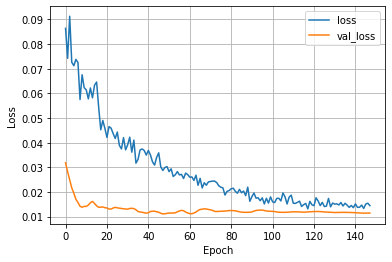

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_loss(history)

In [21]:
test_results = basic_model.evaluate(
    test_features[train_col_name],
    test_labels, verbose=1)

2/2 [==============================] - 0s 5ms/step - loss: 0.0125


In [22]:
test_input_feature = np.array(test_features[train_col_name])

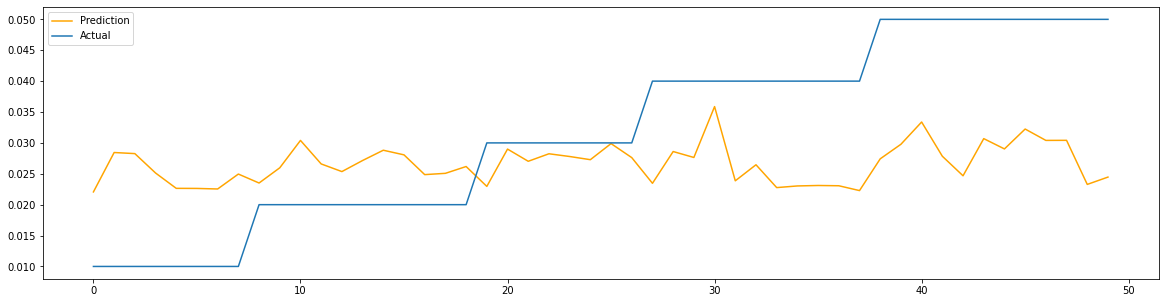

In [23]:
pred_y = basic_model.predict(test_input_feature)
plt.figure(figsize=(20,5))
actual_trend=test_labels.values
plt.plot(pred_y, color='orange', label='Prediction')
plt.plot(actual_trend, label='Actual')
plt.legend()

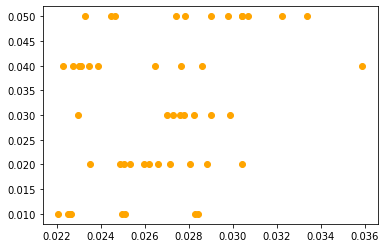

In [24]:
test_input_feature = np.array(test_features[train_col_name])
pred_y = basic_model.predict(test_input_feature)
# plt.figure(figsize=(20,5))
actual_trend=test_labels.values
plt.scatter(pred_y,actual_trend,  color='orange')
plt.show()